In [7]:
import math
import numpy as np
import pandas as pd
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA
import pmdarima as pm
import time
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import plot_importance, plot_tree
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [8]:
full_df = pd.read_csv('../data/m4/daily-train.csv')

def get_ts(full_df, index):
    df = full_df.iloc[index:index+1, 1:].transpose()
    df.columns = ['y']
    df = df[df['y'].notna()]
    return df

# df = get_ts(full_df, 6)
df = get_ts(full_df, 1)
df.tail()

,y
V1003,2978.0
V1004,2991.9
V1005,2995.3
V1006,3000.5
V1007,2968.5


In [9]:
def generate_serial_lags(feature_count):
    return list(range(1, feature_count + 1))

def get_features_from_lags(df, lag_count=7, lags=None, keep_y=False, method="ratio"):
    """ Generates the feature (lags) that can than be used to forecast
        if the *lags* parameter is used, then the function will use the lags specified by this parameter and will
            ignore the lag_count parameter
        if lags is not used, the function will generate a sequence of features
            like [lag_1, lag_2, ..., lag_lag_count]
    """
    assert method in ['ratio', 'difference'], "method must be one of ['ratio', 'difference']"
    res = df[['y']].copy()
    
    if lags is None:
        lags = generate_serial_lags(lag_count)
    
    # The lags are computed for the *previous* value because when we forecast,
    # we cannot compute them for the current value
    res['previous'] = res['y'].shift(1)
    for lag in lags:
        if method == "ratio":
            res['lag_{}'.format(lag)] = res['previous'] / res['previous'].shift(lag) * 100
        else:
            res['lag_{}'.format(lag)] = res['previous'] - res['previous'].shift(lag)
    
#     res['day'] = np.arange(res.shape[0]) % 7
    if method == "ratio":
        res['lag_to_predict'] = res['y'] / res['previous'] * 100
    else:
        res['lag_to_predict'] = res['y'] - res['previous']
    
    # Ignore the first row, as it has no previous values, it cannot be predicted
    if keep_y:
        columns_to_drop = ['previous']
    else:
        columns_to_drop = ['previous', 'y']
    return res[1:].drop(columns_to_drop, axis=1)

get_features_from_lags(df, lags=[1, 2, 3, 4, 5, 6, 7])

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_to_predict
V3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.003579
V4,100.003579,NaN,NaN,NaN,NaN,NaN,NaN,100.354356
V5,100.354356,100.357948,NaN,NaN,NaN,NaN,NaN,100.074901
V6,100.074901,100.429523,100.433117,NaN,NaN,NaN,NaN,99.875258
V7,99.875258,99.950066,100.304245,100.307835,NaN,NaN,NaN,99.739500
...,...,...,...,...,...,...,...,...
V1003,98.625715,97.647679,97.490297,97.699179,98.155385,98.019049,97.689519,100.475725
V1004,100.475725,99.094902,98.112213,97.954082,98.163958,98.622334,98.485350,100.466756
V1005,100.466756,100.944701,99.557434,98.570158,98.411289,98.622145,99.082660,100.113640
V1006,100.113640,100.580927,101.059415,99.670571,98.682173,98.523123,98.734219,100.173605


In [10]:
def train_xgb(df, in_sample_validation=False):
    xgb_reg_params = {
    #         'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.1)),
        'learning_rate': 0.01,
        'max_depth':        5,
        'early_stopping_rounds': 10000,
        'eval_metric': 'rmse',
        'n_estimators': 8000,
    }

    if in_sample_validation:
        # Validate against in sample data
        train = df
        validation = df
    else:
        # Validate against out of sample
#         train = df[:-50]
#         validation = df[-50:]
        train, validation = train_test_split(df, test_size = 0.1)

    X_train = train.drop('lag_to_predict', axis=1)
    y_train = train[['lag_to_predict']]


    reg = xgb.XGBRegressor(**xgb_reg_params)
    eval_set = [(validation.drop('lag_to_predict', axis=1), validation[['lag_to_predict']])]
    reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    return reg

# Use this method to convert from ratio prediction to actual y_hat which
# can be compared to 'y' from original df
def ratio_to_actual(df, predictions):
    df = df.copy()
    df['yhat'] = (df['y'] * predictions / 100).shift(1)
    return df

# Use this method to convert from lagged difference prediction to actual y_hat which
# can be compared to 'y' from original df
def lagged_diff_to_actual(df, predictions):
    df = df.copy()
    df['yhat'] = (df['y'] + predictions).shift(1)
    return df

def predict_xgb(df, model):
    return model.predict(df)

#The following ts can be used to showcase seasonality:61,71?,81,226, 246, 264
df = get_ts(full_df, 61)
lgs = get_features_from_lags(df, lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
train_df = lgs[:-10]
test_df = lgs[-10:].copy()
# test_df

model = train_xgb(train_df)
test_df['lag_hat'] = predict_xgb(test_df.drop('lag_to_predict', axis=1), model)
ratio_to_actual(df[-10:], test_df['lag_hat'])
# # plot_importance(model)

,y,yhat
V123,5862.5,NaN
V124,5895.0,5883.524527
V125,5940.0,5957.437383
V126,5972.5,5884.898923
V127,5942.5,6030.257436
V128,5875.0,6005.519824
V129,5867.0,5935.266352
V130,5715.0,5785.686420
V131,5660.0,5631.299876
V132,5659.0,5722.424438


In [11]:
def get_preds(df):
    train_df = lgs[:-10]
    test_df = lgs[-10:].copy()

    model = train_xgb(train_df)
    test_df['lag_hat'] = predict_xgb(test_df.drop('lag_to_predict', axis=1), model)

    return test_df


index = 61


df = get_ts(full_df, index)

all_results = []
for method in ['ratio', 'difference']:
    lgs = get_features_from_lags(df, lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], method=method)
    preds = get_preds(lgs)
    
    # First row does not have a prediction so drop it
#     preds = preds.iloc[1:,:]
    
    if method == 'ratio':
        res_df = ratio_to_actual(df[-preds.shape[0]:], preds['lag_hat'])
    else:
        res_df = lagged_diff_to_actual(df[-preds.shape[0]:], preds['lag_hat'])

    res_df['ts_index'] = index
    res_df['method'] = method
    all_results.extend(res_df.to_dict('records'))

pd.DataFrame(all_results)

,y,yhat,ts_index,method
0,5862.5,NaN,61,ratio
1,5895.0,5825.649157,61,ratio
2,5940.0,5929.747002,61,ratio
3,5972.5,5923.857967,61,ratio
4,5942.5,5945.955201,61,ratio
5,5875.0,5962.526105,61,ratio
6,5867.0,5895.580339,61,ratio
7,5715.0,5892.008786,61,ratio
8,5660.0,5694.725075,61,ratio
9,5659.0,5707.934593,61,ratio


In [6]:
def get_preds(df):
    train_df = lgs[:-10]
    test_df = lgs[-10:].copy()

    model = train_xgb(train_df)
    test_df['lag_hat'] = predict_xgb(test_df.drop('lag_to_predict', axis=1), model)

    return test_df


index = 61

all_results = []

for index in tqdm(full_df.shape[0]):
    df = get_ts(full_df, index)
    for method in ['ratio', 'difference']:
        lgs = get_features_from_lags(df, lags = [1, 2, 3, 4, 5, 6, 7], method=method)
        preds = get_preds(lgs)

        if method == 'ratio':
            res_df_ratio = ratio_to_actual(df[-preds.shape[0]:], preds['lag_hat']).iloc[1:, :]
        else:
            res_df_diffs = lagged_diff_to_actual(df[-preds.shape[0]:], preds['lag_hat']).iloc[1:, :]

        # First row does not have a prediction that we can compare so drop it
        # (that is because we don't have previous values to predict on)
    res_df_all = res_df_ratio.copy()
    res_df_all.rename(columns={'yhat':'yhat_ratio'}, inplace=True)
    res_df_all['yhat_diffs'] = res_df_diffs['yhat']
    res_df_all['ts_index'] = index
    res_df_all['method'] = method
    all_results.extend(res_df_all.to_dict('records'))

res_df = pd.DataFrame(all_results)
res_df['mse_ratio'] = (res_df['y'] - res_df['yhat_ratio'])**2
res_df['mse_diffs'] = (res_df['y'] - res_df['yhat_diffs'])**2

print("Ratio performed better in {} ({:2f}%) of the cases".format(
        res_df[res_df['mse_ratio'] < res_df['mse_diffs']].shape[0],
        res_df[res_df['mse_ratio'] < res_df['mse_diffs']].shape[0] / res_df.shape[0] * 100
    )
)

print("MAPE for Ratio is {:2f}".format(mean_absolute_percentage_error(res_df['y'], res_df['yhat_ratio'])))
print("MAPE for Diffs is {:2f}".format(mean_absolute_percentage_error(res_df['y'], res_df['yhat_diffs'])))

res_df

  0%|          | 0/20 [00:00<?, ?it/s]

Ratio performed better in 82 (45.555556%) of the cases
MAPE for Ratio is 0.017049
MAPE for Diffs is 0.017749


,y,yhat_ratio,yhat_diffs,ts_index,method,mse_ratio,mse_diffs
0,2002.9,2009.360899,2008.980016,0,difference,41.743212,36.966595
1,2012.6,2001.851424,2001.075270,0,difference,115.531893,132.819408
2,2013.8,2011.958625,2012.094129,0,difference,3.390662,2.909995
3,2003.4,2012.083218,2013.965670,0,difference,75.398280,111.633376
4,2015.6,2004.038290,2004.070076,0,difference,133.673132,132.939144
...,...,...,...,...,...,...,...
175,10907.1,10807.039848,10851.465012,19,difference,10012.034081,3095.251924
176,10866.0,10873.190063,10906.449546,19,difference,51.697007,1636.165739
177,10865.2,10958.369953,10865.349546,19,difference,8680.640199,0.022364
178,10855.3,10805.087107,10864.549546,19,difference,2521.334603,85.554094


In [8]:
def get_preds(df):
    train_df = lgs[:-10]
    test_df = lgs[-10:].copy()

    model = train_xgb(train_df)
    test_df['lag_hat'] = predict_xgb(test_df.drop('lag_to_predict', axis=1), model)

    return test_df


index = 61

all_results = []

for index in tqdm(range(200)):
    df = get_ts(full_df, index)
    for method in ['ratio', 'difference']:
        lgs = get_features_from_lags(df, lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], method=method)
        preds = get_preds(lgs)

        if method == 'ratio':
            res_df_ratio = ratio_to_actual(df[-preds.shape[0]:], preds['lag_hat']).iloc[1:, :]
        else:
            res_df_diffs = lagged_diff_to_actual(df[-preds.shape[0]:], preds['lag_hat']).iloc[1:, :]

        # First row does not have a prediction that we can compare so drop it
        # (that is because we don't have previous values to predict on)
    res_df_all = res_df_ratio.copy()
    res_df_all.rename(columns={'yhat':'yhat_ratio'}, inplace=True)
    res_df_all['yhat_diffs'] = res_df_diffs['yhat']
    res_df_all['ts_index'] = index
    res_df_all['method'] = method
    all_results.extend(res_df_all.to_dict('records'))

res_df = pd.DataFrame(all_results)
res_df['mape_ratio'] = abs(res_df['y'] - res_df['yhat_ratio'])
res_df['mape_diffs'] = abs(res_df['y'] - res_df['yhat_diffs'])

print("Ratio performed better in {} ({:2f}%) of the cases".format(
        res_df[res_df['mape_ratio'] < res_df['mape_diffs']].shape[0],
        res_df[res_df['mape_ratio'] < res_df['mape_diffs']].shape[0] / res_df.shape[0] * 100
    )
)

print("MAPE for Ratio is {:2f}".format(mean_absolute_percentage_error(res_df['y'], res_df['yhat_ratio'])))
print("MAPE for Diffs is {:2f}".format(mean_absolute_percentage_error(res_df['y'], res_df['yhat_diffs'])))

res_df

  0%|          | 0/200 [00:00<?, ?it/s]

Ratio performed better in 723 (40.166667%) of the cases
MAPE for Ratio is 0.020269
MAPE for Diffs is 0.010923


,y,yhat_ratio,yhat_diffs,ts_index,method,mape_ratio,mape_diffs
0,2002.90,2011.155335,2008.715269,0,difference,8.255335,5.815269
1,2012.60,2002.083235,2003.319111,0,difference,10.516765,9.280889
2,2013.80,2038.715954,2013.096981,0,difference,24.915954,0.703019
3,2003.40,2012.095202,2014.298049,0,difference,8.695202,10.898049
4,2015.60,2005.448459,2003.895000,0,difference,10.151541,11.705000
...,...,...,...,...,...,...,...
1795,6900.00,6860.757568,6863.317342,199,difference,39.242432,36.682658
1796,6868.75,6882.090385,6900.346382,199,difference,13.340385,31.596382
1797,6843.75,6853.341533,6869.567342,199,difference,9.591533,25.817342
1798,6884.38,6842.795534,6844.096382,199,difference,41.584466,40.283618


<AxesSubplot:>

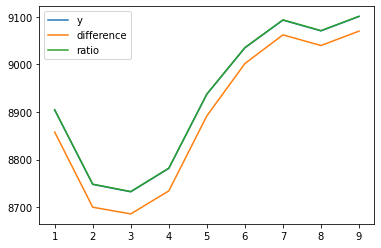

In [51]:
# Plot predictions for both methods vs actuals

# Non stationary variance: 3, 157, 117, 165, 222, 341, 123
df = get_ts(full_df, 117)

all_results = {
    'ratio': [], 
    'difference': []
}
for method in ['ratio', 'difference']:
    lgs = get_features_from_lags(df, lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], method=method)
    preds = get_preds(lgs)
    
    # First row does not have a prediction so drop it
#     preds = preds.iloc[1:,:]
    
    if method == 'ratio':
        res_df = ratio_to_actual(df[-preds.shape[0]:], preds['lag_hat'])
    else:
        res_df = lagged_diff_to_actual(df[-preds.shape[0]:], preds['lag_hat'])

    res_df['ts_index'] = index
    res_df['method'] = method
    res_df
#     all_results.extend(res_df.to_dict('records'))
    all_results[method] = res_df.to_dict('records')
    
# pd.DataFrame(all_results['ratio'])
df1 = pd.DataFrame(all_results['ratio'])
df2 = pd.DataFrame(all_results['difference'])
fin_df = df1.merge(df2, left_index=True, right_index=True).drop(
    ['ts_index_x', 'method_x', 'y_y', 'ts_index_y', 'method_y'], axis=1)
fin_df.columns = ['y', 'difference', 'ratio']
fin_df['y'] = fin_df['y'].shift()
fin_df.plot()

In [52]:
print("".join(["({},{})".format(i+1,v) for i,v in enumerate(df['y'].tolist())]))

(1,18640.6)(2,18410.7)(3,16447.0)(4,16741.3)(5,18615.4)(6,18088.6)(7,19467.7)(8,21230.2)(9,22651.0)(10,23281.3)(11,22821.7)(12,23696.6)(13,25896.9)(14,28916.9)(15,27330.2)(16,26303.6)(17,22952.4)(18,23752.5)(19,22692.1)(20,23511.9)(21,23690.7)(22,24738.6)(23,26151.1)(24,25197.2)(25,25176.1)(26,24182.7)(27,25368.3)(28,24026.0)(29,22895.9)(30,21786.2)(31,21350.1)(32,20976.5)(33,20702.9)(34,21765.1)(35,21488.3)(36,23877.3)(37,24419.4)(38,23005.0)(39,23691.1)(40,23252.8)(41,22102.6)(42,20666.5)(43,20491.3)(44,20982.9)(45,19139.0)(46,18609.9)(47,19034.7)(48,19876.3)(49,19264.8)(50,17740.9)(51,18032.9)(52,16811.2)(53,17057.3)(54,17133.8)(55,16616.5)(56,17324.9)(57,18480.7)(58,18388.1)(59,18572.7)(60,18361.3)(61,19279.1)(62,19652.1)(63,18673.5)(64,19105.1)(65,19078.3)(66,16900.8)(67,16930.3)(68,16328.8)(69,16916.1)(70,16133.6)(71,15218.2)(72,17098.6)(73,16229.0)(74,15551.0)(75,16723.8)(76,15437.9)(77,15379.9)(78,13849.6)(79,14155.4)(80,14513.3)(81,14999.6)(82,15787.3)(83,16707.2)(84,16148.7)(

In [53]:
print("".join(["({},{:.2f})".format(i+1,v) for i,v in enumerate(df[['y']].diff()['y'].tolist())]))

(1,nan)(2,-229.90)(3,-1963.70)(4,294.30)(5,1874.10)(6,-526.80)(7,1379.10)(8,1762.50)(9,1420.80)(10,630.30)(11,-459.60)(12,874.90)(13,2200.30)(14,3020.00)(15,-1586.70)(16,-1026.60)(17,-3351.20)(18,800.10)(19,-1060.40)(20,819.80)(21,178.80)(22,1047.90)(23,1412.50)(24,-953.90)(25,-21.10)(26,-993.40)(27,1185.60)(28,-1342.30)(29,-1130.10)(30,-1109.70)(31,-436.10)(32,-373.60)(33,-273.60)(34,1062.20)(35,-276.80)(36,2389.00)(37,542.10)(38,-1414.40)(39,686.10)(40,-438.30)(41,-1150.20)(42,-1436.10)(43,-175.20)(44,491.60)(45,-1843.90)(46,-529.10)(47,424.80)(48,841.60)(49,-611.50)(50,-1523.90)(51,292.00)(52,-1221.70)(53,246.10)(54,76.50)(55,-517.30)(56,708.40)(57,1155.80)(58,-92.60)(59,184.60)(60,-211.40)(61,917.80)(62,373.00)(63,-978.60)(64,431.60)(65,-26.80)(66,-2177.50)(67,29.50)(68,-601.50)(69,587.30)(70,-782.50)(71,-915.40)(72,1880.40)(73,-869.60)(74,-678.00)(75,1172.80)(76,-1285.90)(77,-58.00)(78,-1530.30)(79,305.80)(80,357.90)(81,486.30)(82,787.70)(83,919.90)(84,-558.50)(85,594.20)(86,464.8

In [54]:
print("".join(["({},{:.6f})".format(i+1,v) for i,v in enumerate((df[['y']] / df[['y']].shift())['y'].tolist())]))

(1,nan)(2,0.987667)(3,0.893339)(4,1.017894)(5,1.111945)(6,0.971701)(7,1.076241)(8,1.090535)(9,1.066924)(10,1.027827)(11,0.980259)(12,1.038336)(13,1.092853)(14,1.116616)(15,0.945129)(16,0.962437)(17,0.872595)(18,1.034859)(19,0.955356)(20,1.036127)(21,1.007605)(22,1.044233)(23,1.057097)(24,0.963524)(25,0.999163)(26,0.960542)(27,1.049027)(28,0.947088)(29,0.952963)(30,0.951533)(31,0.979983)(32,0.982501)(33,0.986957)(34,1.051307)(35,0.987282)(36,1.111177)(37,1.022704)(38,0.942079)(39,1.029824)(40,0.981499)(41,0.950535)(42,0.935026)(43,0.991523)(44,1.023991)(45,0.912124)(46,0.972355)(47,1.022827)(48,1.044214)(49,0.969235)(50,0.920897)(51,1.016459)(52,0.932252)(53,1.014639)(54,1.004485)(55,0.969808)(56,1.042632)(57,1.066713)(58,0.994989)(59,1.010039)(60,0.988618)(61,1.049986)(62,1.019347)(63,0.950204)(64,1.023113)(65,0.998597)(66,0.885865)(67,1.001745)(68,0.964472)(69,1.035967)(70,0.953742)(71,0.943261)(72,1.123563)(73,0.949142)(74,0.958223)(75,1.075416)(76,0.923110)(77,0.996243)(78,0.900500)

In [55]:
print("".join(["({},{})".format(i+1,v) for i,v in enumerate(fin_df[1:]['y'].tolist())]))
print("")
print("".join(["({},{:.2f})".format(i+1,v) for i,v in enumerate(fin_df[1:]['difference'].tolist())]))
print("")
print("".join(["({},{:.2f})".format(i+1,v) for i,v in enumerate(fin_df[1:]['ratio'].tolist())]))

(1,8904.4)(2,8748.0)(3,8732.5)(4,8781.6)(5,8937.4)(6,9034.9)(7,9093.1)(8,9070.5)(9,9100.7)

(1,8858.03)(2,8700.14)(3,8686.03)(4,8734.39)(5,8891.99)(6,9001.90)(7,9062.12)(8,9039.74)(9,9070.01)

(1,8904.94)(2,8748.54)(3,8733.04)(4,8782.14)(5,8937.94)(6,9035.44)(7,9093.64)(8,9071.04)(9,9101.24)
